In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from utils.predictiveNet import PredictiveNet
from utils.agent import RandomActionAgent
import itertools
import torch
import random
from utils.env import make_env
from utils.general import saveFig
import matplotlib.pyplot as plt


from analysis.OfflineTrajectoryAnalysis import OfflineTrajectoryAnalysis
from analysis.OfflineActivityAnalysis import SpontaneousActivityAnalysis
from analysis.representationalGeometryAnalysis import representationalGeometryAnalysis

In [3]:
savefolder = 'Figures/MultiMaskCogMap/'

In [4]:
#Example Net
netname = 'AutoencoderPred_LN'
netfolder = '/Autoencoder_sparse_panel/'
exseed = 102
predictiveNet = PredictiveNet.loadNet(netfolder+netname+'-Onehot-s'+str(exseed))

Net Loaded from pathname


In [5]:
predictiveNet.trainArgs

Namespace(actenc='Onehot', bias_lr=0.1, bptttrunc=100000000.0, contin=False, dropout=0.15, env='MiniGrid-LRoom-18x18-v0', hiddensize=500, identityInit=False, load_env=-1, loadfolder='', lr=0.002, namext='Onehot', noisemean=0, noisestd=0.03, ntimescale=2.0, numepochs=80, numtrials=1000, pRNNtype='AutoencoderPred_LN', saveTrainData=False, savefolder='Autoencoder_sparse_panel/', seed=102, seqdur=600, sparsity=0.5, trainBias=True, weight_decay=0.003)

In [38]:
sleepnoise = 0.1
isomap_neighbors = 15
RGA = representationalGeometryAnalysis(predictiveNet,noisemag = 0, noisestd=sleepnoise, 
                                       withIsomap=True, n_neighbors = isomap_neighbors)

Running WAKE


/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/representationalGeometryAnalysis.py:313: RuntimeWarning: invalid value encountered in divide
  hist2 = hist2/np.sum(hist2,axis=0)
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Running SLEEP
Fitting Isomap


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


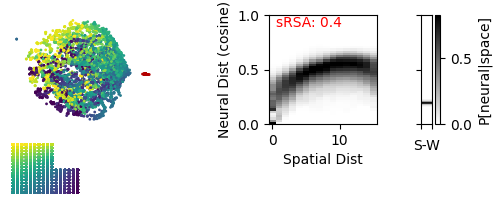

In [55]:
RGA.WakeSleepFigure(netname,savefolder)

In [10]:
from utils.CANNNet import CANNnet
env = predictiveNet.EnvLibrary[0]
CANNNet = CANNnet(env,trainNoiseMeanStd=(0,0.03),
                 connectionWidth=1,inputWidth=3,inputStrength=6)
CANNNet = CANNnet(env,trainNoiseMeanStd=(0,0.3),
                 connectionWidth=1,inputWidth=3,inputStrength=6)

AttributeError: 'CANNnet' object has no attribute 'EnvLibrary'

In [ ]:
RGA_CANN = representationalGeometryAnalysis(CANNNet,timesteps_wake = 5000,
                                            noisemag = 0, noisestd = sleepnoise, withIsomap=True)

In [ ]:
RGA_CANN.WakeSleepFigure('CANNControl',savefolder)

In [12]:
nettypes = ['thRNN']
kvalues = ['0','1','2','3','4','5','6']
masks = ['']
#seeds = ['30','31','32','33','34','35']
seeds = ['100','101','102','103','104','105','106','107','108']
aEncs = ['Onehot','SpeedHD','Velocities']

netprops = itertools.product(*[nettypes,['_'],kvalues,['win'],masks,['-'],aEncs,['-s'],seeds])
netprops = list(netprops)
netnames = [''.join(name) for name in netprops]
nettype = ['Mask k'+name[2] for name in netprops]
netmask = [name[4] for name in netprops]
netAE = [name[6] for name in netprops]
netseed = [int(name[8]) for name in netprops]

netk = [int(name[2]) for name in netprops]
netfolder = '/maskedk_panel/'

analysisFrame_kpanel = pd.DataFrame(data={'filename':netnames, 'type':nettype, 'mask':netmask, 'k':netk,
                                   'ActionEnc':netAE, 'seed':netseed, 'netfolder':netfolder})

In [13]:
nettypes = ['AutoencoderPred_LN']
aEncs = ['Onehot','SpeedHD','Velocities']
#seeds = ['0','2','3','4','5']
#seeds = ['0','2','3','4','5']
#seeds = ['0','1','3','4','5']
#lr = [1e-4,1.5e-4,3e-4,5.5e-4,1e-3,1.5e-3,3e-3]

netprops = itertools.product(*[nettypes,['-'],aEncs,['-s'],seeds])
netprops = list(netprops)
netnames = [''.join(name) for name in netprops]
nettype = [name[0] for name in netprops]
#netmask = [name[4] for name in netprops]
netAE = [name[2] for name in netprops]
netseed = [int(name[4]) for name in netprops]
netfolder = '/Autoencoder_sparse_panel/'


analysisFrame_sparse = pd.DataFrame(data={'filename':netnames, 'type':'N-S (+LN)', 'ActionEnc':netAE, 'seed':netseed,
                                      'netfolder':netfolder})

In [14]:
analysisFrame = pd.concat([analysisFrame_sparse, analysisFrame_kpanel])

In [16]:

def loadNet(row):
    try:
        net = PredictiveNet.loadNet(row['netfolder']+row['filename'],suppressText=True)
        return net
    except:
        print(f"{row['filename']} does not exist")
        #net = PredictiveNet
        net = None
        return net

#analysisFrame['net'] = analysisFrame.apply(loadNet, axis = 1)

In [57]:
#Calculate spatial info and decoding performance
def getSpatialRep(row):
    predictiveNet = loadNet(row)
    if predictiveNet == None:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    #predictiveNet= row.net
    #print(len(predictiveNet.TrainingSaver['sRSA'].values))
    try:
        SI = predictiveNet.TrainingSaver['SI'].values[-1]
        sRSA = predictiveNet.TrainingSaver['sRSA'].values[-1]

        EVs = predictiveNet.TrainingSaver['EVs'].values[-1]
        
        SWdist = predictiveNet.TrainingSaver['SWdist'].values[-1]
        finalLoss = predictiveNet.TrainingSaver['loss'].values[-1]
    except:
        SI = predictiveNet.TrainingSaver['SI']
        sRSA = predictiveNet.TrainingSaver['sRSA']

        EVs = predictiveNet.TrainingSaver['EVs']
        
        SWdist = predictiveNet.TrainingSaver['SWdist']
        finalLoss = predictiveNet.TrainingSaver['loss']
        
    meanSI = np.nanmean(SI)
    EVsp50 = np.nanmean(EVs>0.5)
    tunedSI = np.nanmean(SI[EVs>0.5])
    
    return SI, meanSI, sRSA, EVs, EVsp50, finalLoss, SWdist, tunedSI
analysisFrame[['SI','meanSI','sRSA','EVs','EVs50','finalLoss','SWdist','tunedSI']] = analysisFrame.apply(getSpatialRep, axis = 1, result_type="expand")

/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


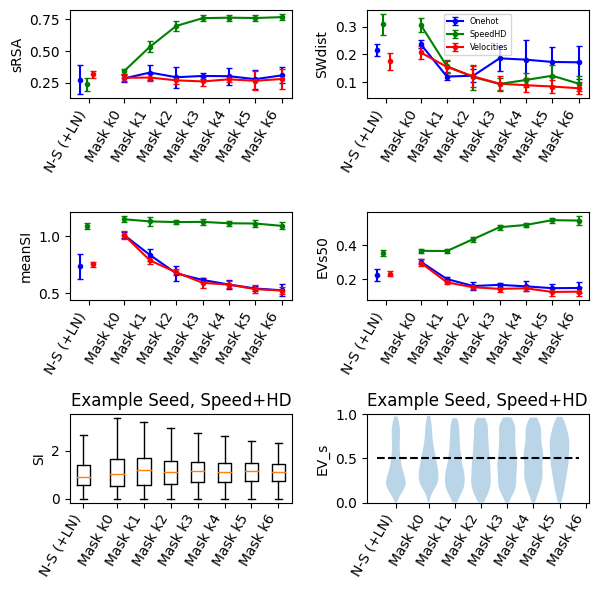

In [92]:
#CANN_sRSA = RGA_CANN.RSA_cs[0][0]
#CANN_SW = RGA_CANN.SWdist_cs[0]
#stats: all nets, mean SI, p50, sRSA, SWDist (compare action encodings), mean+/- std over seeds
#example nets: SI distribution and EV distribution (Speed+HD all)
examplenets = (analysisFrame['ActionEnc']=='SpeedHD') & (analysisFrame['seed']==exseed)
plt.figure(figsize=(6,6))

maskedidx = np.arange(1,8)
NSidx = np.arange(0,1)
colors = ['blue','green','red','purple']
metrics = ['sRSA','SWdist','meanSI','EVs50']
for aidx,act in enumerate(analysisFrame['ActionEnc'].unique()):
    data = analysisFrame[analysisFrame['ActionEnc']==act][metrics+['type']]
    panel = data.groupby('type',sort=False).agg([np.mean, np.std])


    for idx,metric in enumerate(metrics):   
        plt.subplot(3,2,1+idx)
        plt.errorbar(maskedidx,panel[metric]['mean'][maskedidx], 
                         panel[metric]['std'][maskedidx],
                    capsize=2,fmt='.-',color=colors[aidx],label=act)
        plt.errorbar(NSidx+0.25*aidx-0.66,panel[metric]['mean'][NSidx], 
                         panel[metric]['std'][NSidx],
                    capsize=2,fmt='.',color=colors[aidx])
        plt.ylabel(metric)
        plt.gca().set_xticks(np.concatenate([NSidx-0.33,maskedidx]), labels=panel.index)
        plt.xticks(rotation=60, ha='right')
        #if metric == 'sRSA':
        #    plt.plot([NSidx[0]-0.33,maskedidx[-1]],[CANN_sRSA,CANN_sRSA],'k--')
        #if metric == 'SWdist':
        #    #plt.plot([NSidx[0]-0.33,maskedidx[-1]],[CANN_SW,CANN_SW],'k--')
        if idx==1:
            plt.legend(fontsize='xx-small')

plt.subplot(3,2,5)
plt.boxplot( analysisFrame[examplenets]['SI'], showfliers=False,
           labels = analysisFrame[examplenets]['type'],
           positions=np.concatenate([NSidx-0.25,maskedidx]))
plt.xticks(rotation=60, ha='right')
plt.ylabel('SI')
plt.title('Example Seed, Speed+HD')

plt.subplot(3,2,6)
plt.violinplot(analysisFrame[examplenets]['EVs'],showextrema=False,widths=0.75,
              positions=np.concatenate([NSidx-0.25,maskedidx]))
plt.plot(plt.xlim(),[0.5,0.5],'k--')
plt.xticks(rotation=60, ha='right')
plt.ylim([0,1])
plt.ylabel('EV_s')
plt.title('Example Seed, Speed+HD')
plt.gca().set_xticks(np.concatenate([NSidx-0.25,maskedidx]), labels=panel.index)
 
plt.tight_layout()

saveFig(plt.gcf(),'CompareNets',savefolder,
        filetype='pdf')

plt.show()

In [17]:
exk = 5
#exseed = 12
exnet_k6 = (analysisFrame.seed==exseed)&(analysisFrame.k==exk)&(analysisFrame.ActionEnc=='SpeedHD')
exnet_k1 = (analysisFrame.seed==exseed)&(analysisFrame.k==1)&(analysisFrame.ActionEnc=='SpeedHD')
#xnet_LN = (analysisFrame.seed==exseed)&(analysisFrame.type == 'N-S (+LN)')&(analysisFrame.ActionEnc=='Onehot')
analysisFramek1 = analysisFrame.loc[exnet_k1].apply(loadNet, axis = 1)
analysisFramek6 = analysisFrame.loc[exnet_k6].apply(loadNet, axis = 1)

predictiveNet_k1 = analysisFramek1.values[0]
predictiveNet_k6 = analysisFramek6.values[0]
#predictiveNet_LN = analysisFrame[exnet_LN]['net'].values[0]

In [46]:
RGA_mask = representationalGeometryAnalysis(predictiveNet_k6,noisemag = 0, noisestd=sleepnoise, 
                                            withIsomap=True, n_neighbors = isomap_neighbors)

Running WAKE


/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/representationalGeometryAnalysis.py:313: RuntimeWarning: invalid value encountered in divide
  hist2 = hist2/np.sum(hist2,axis=0)
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Running SLEEP
Fitting Isomap


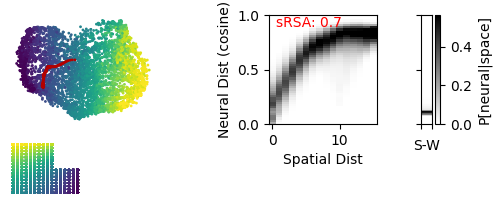

In [53]:
RGA_mask.WakeSleepFigure('k'+str(exk),savefolder)

Running WAKE


/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/representationalGeometryAnalysis.py:313: RuntimeWarning: invalid value encountered in divide
  hist2 = hist2/np.sum(hist2,axis=0)
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Running SLEEP
Fitting Isomap


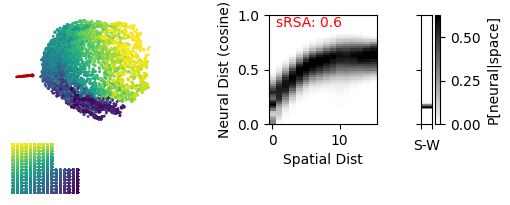

In [54]:
RGA_k1 = representationalGeometryAnalysis(predictiveNet_k1,noisemag = 0, noisestd=sleepnoise, 
                                          withIsomap=True,n_neighbors = isomap_neighbors)
RGA_k1.WakeSleepFigure('k1',savefolder)

In [23]:
from analysis.SpatialTuningAnalysis import SpatialTuningAnalysis



Running WAKE
Calculating EV_s


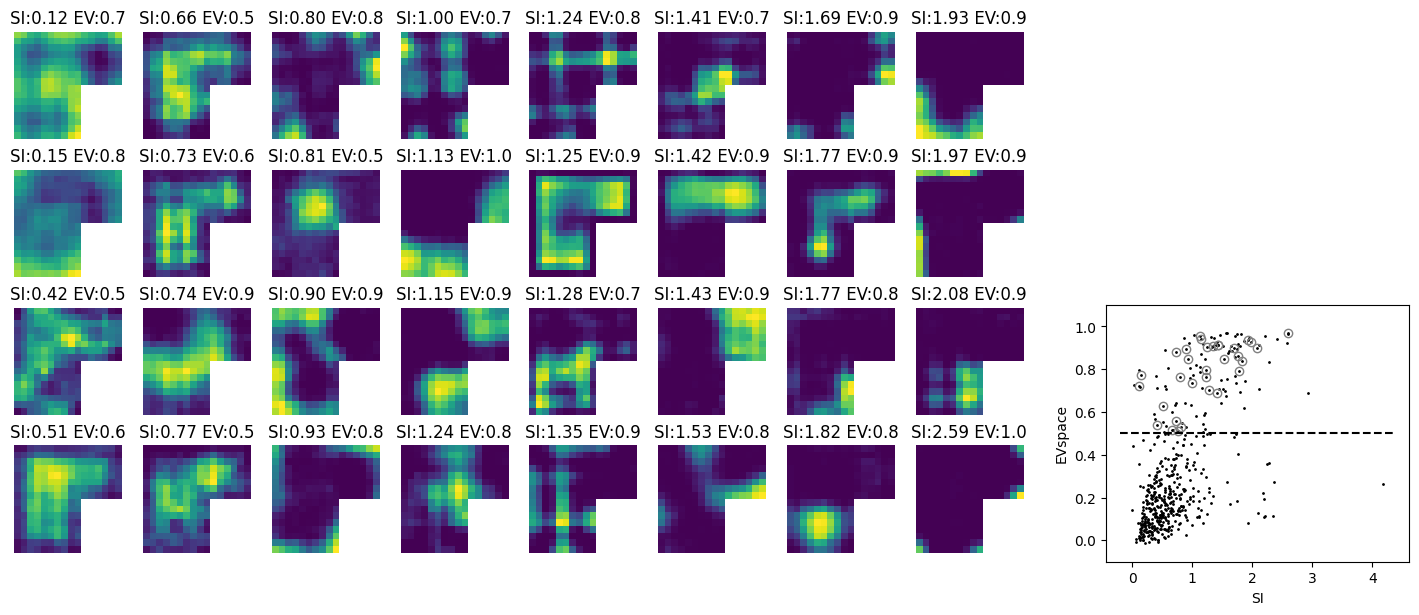

In [24]:
STA_NS = SpatialTuningAnalysis(predictiveNet,inputControl=False, untrainedControl=False)
STA_NS.TCExamplesFigure(netname='LN',savefolder=savefolder)

Getting Tuning Curves for Input Units
Running WAKE
Calculating EV_s
Calculating EV_s for input control


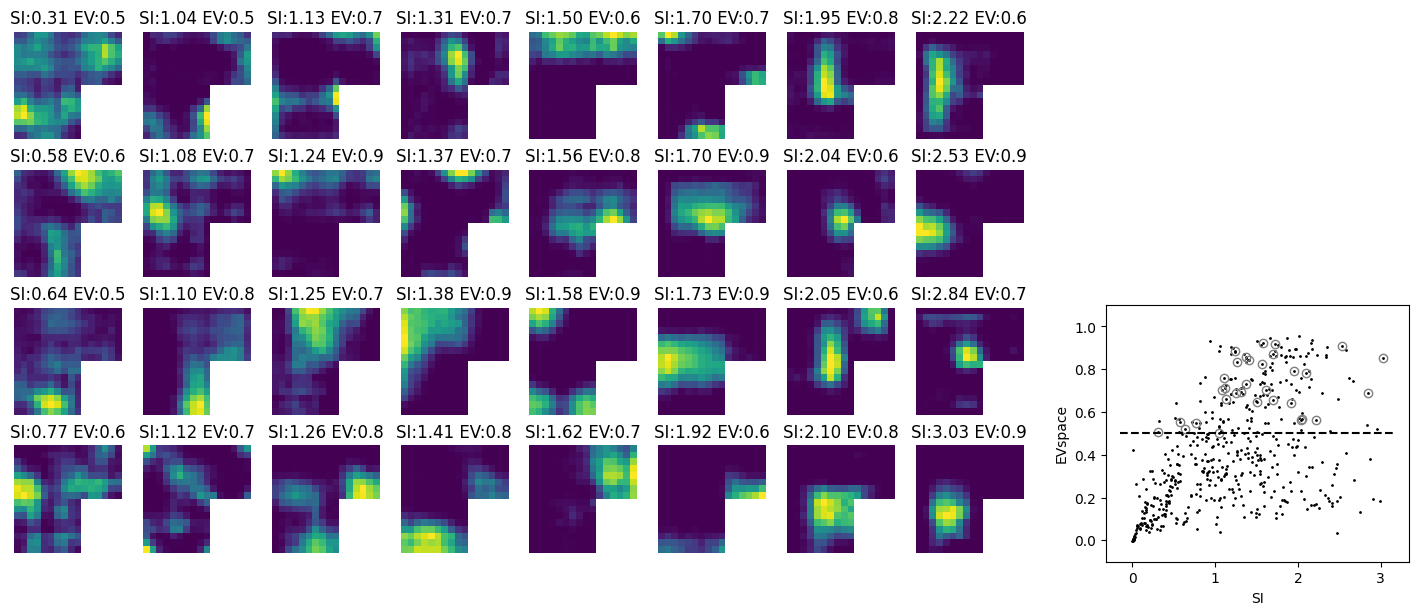

In [25]:
STA_k1 = SpatialTuningAnalysis(predictiveNet_k1,inputControl=True, untrainedControl=False)
STA_k1.TCExamplesFigure(netname='k1',savefolder=savefolder)

Getting Tuning Curves for Input Units


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:340: RuntimeWarning: invalid value encountered in divide
  fxfr = fx / fr
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:351: RuntimeWarning: invalid value encountered in divide
  SI = SI / fr[:, 0, 0]


Running WAKE
Calculating EV_s
Calculating EV_s for input control


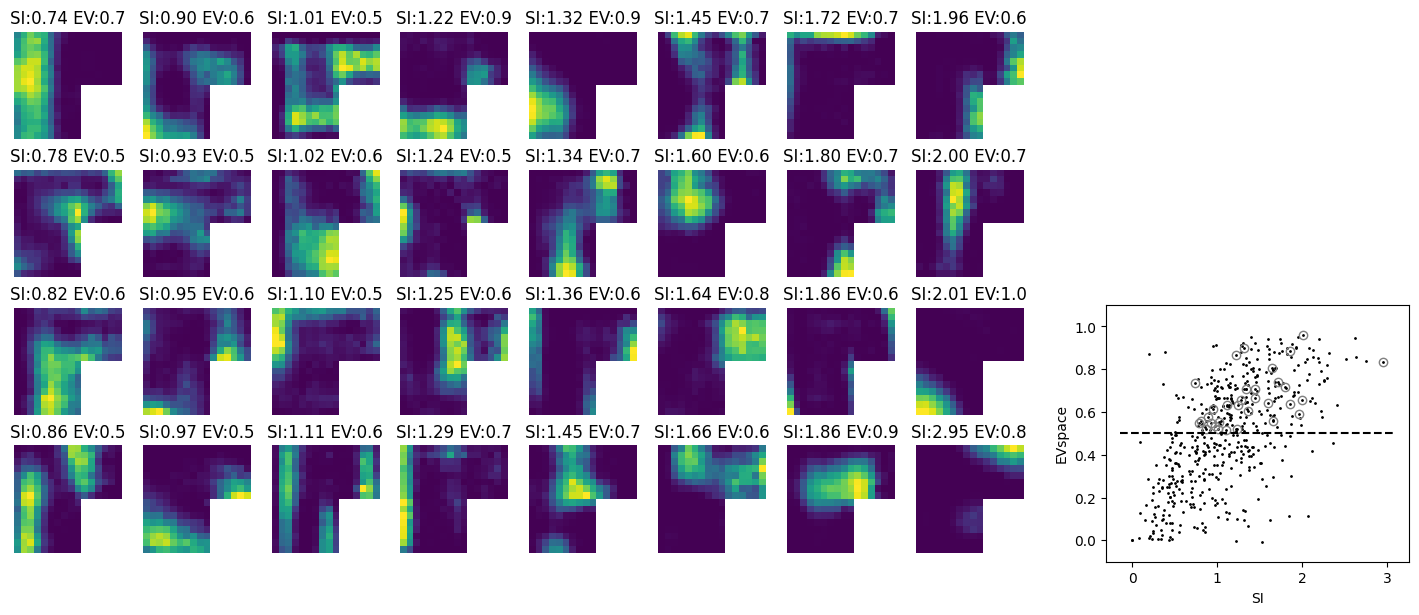

In [26]:
STA_k6 = SpatialTuningAnalysis(predictiveNet_k6,inputControl=True, untrainedControl=False)
STA_k6.TCExamplesFigure(netname='k'+str(exk),savefolder=savefolder)

In [87]:
#Calculate spatial info and decoding performance
def getRSA(row):
    predictiveNet = loadNet(row)
    
    RSA_cb = predictiveNet.TrainingSaver['RSA_cb_space'].values[-1]
    RSA_eu = predictiveNet.TrainingSaver['RSA_eu_space'].values[-1]
    
    return RSA_cb,RSA_eu
analysisFrame[['RSA_cb','RSA_eu']] = analysisFrame.apply(getRSA, axis = 1, result_type="expand")

In [88]:
analysisFrame['euBonus'] = analysisFrame['RSA_eu']-analysisFrame['RSA_cb']

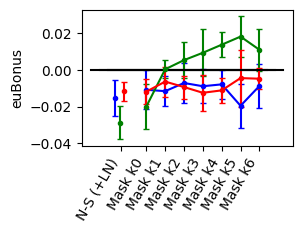

In [93]:
#CANN_sRSA = RGA_CANN.RSA_cs[0][0]
#CANN_SW = RGA_CANN.SWdist_cs[0]
#stats: all nets, mean SI, p50, sRSA, SWDist (compare action encodings), mean+/- std over seeds
#example nets: SI distribution and EV distribution (Speed+HD all)
plt.figure(figsize=(6,6))

#maskedidx = np.arange(1,8)
#NSidx = np.arange(0,1)
metrics = ['euBonus']
for aidx,act in enumerate(analysisFrame['ActionEnc'].unique()):
    data = analysisFrame[analysisFrame['ActionEnc']==act][metrics+['type']]
    panel = data.groupby('type',sort=False).agg([np.mean, np.std])


    for idx,metric in enumerate(metrics):   
        plt.subplot(3,2,1+idx)
        plt.errorbar(maskedidx,panel[metric]['mean'][maskedidx], 
                         panel[metric]['std'][maskedidx],
                    capsize=2,fmt='.-',color=colors[aidx],label=act)
        plt.errorbar(NSidx+0.25*aidx-0.66,panel[metric]['mean'][NSidx], 
                         panel[metric]['std'][NSidx],
                    capsize=2,fmt='.',color=colors[aidx])
        plt.ylabel(metric)
        plt.gca().set_xticks(np.concatenate([NSidx-0.33,maskedidx]), labels=panel.index)
        plt.xticks(rotation=60, ha='right')
        #if metric == 'sRSA':
        #    plt.plot([NSidx[0]-0.33,maskedidx[-1]],[CANN_sRSA,CANN_sRSA],'k--')
        #if metric == 'SWdist':
        #    #plt.plot([NSidx[0]-0.33,maskedidx[-1]],[CANN_SW,CANN_SW],'k--')
        if idx==1:
            plt.legend(fontsize='xx-small')
            
        plt.plot(plt.xlim(),[0,0],'k')
           
saveFig(plt.gcf(),'EuclidianCityblock2',savefolder,
            filetype='pdf')

plt.show()

In [27]:
nettypes = ['thRNN_5win']
kvalues = ['2']
hpidx = ['0','1','2','3','4','5','6','7','8','9','10',
         '11','12','13','14','15','16','17','18','19']
seeds = ['0','1','2','3','4','5','6','7','8','9']
#lr = [1e-4,1.5e-4,3e-4,5.5e-4,1e-3,1.5e-3,3e-3]

netprops = itertools.product(*[nettypes,['-'],hpidx,['-s'],seeds])
netprops = list(netprops)
netnames = [''.join(name) for name in netprops]
nettype = [name[0] for name in netprops]
#netmask = [name[4] for name in netprops]
netk = [int(name[2]) for name in netprops]
netfolder = '/hyperparm_panel_masked/'

analysisFrame_masked = pd.DataFrame(data={'filename':netnames, 'type':nettype, 'netfolder':netfolder})

In [33]:
nettypes = ['thRNN_1win']
kvalues = ['2']
hpidx = ['0','1','2','3','4','5','6','7','8','9','10',
         '11','12','13','14','15','16','17','18','19']
seeds = ['0','1','2','3','4','5','6','7','8','9']
#lr = [1e-4,1.5e-4,3e-4,5.5e-4,1e-3,1.5e-3,3e-3]

netprops = itertools.product(*[nettypes,['-'],hpidx,['-s'],seeds])
netprops = list(netprops)
netnames = [''.join(name) for name in netprops]
nettype = [name[0] for name in netprops]
#netmask = [name[4] for name in netprops]
netk = [int(name[2]) for name in netprops]
netfolder = '/hyperparm_panel_masked1_DRAC/'

analysisFrame_masked1 = pd.DataFrame(data={'filename':netnames, 'type':nettype, 'netfolder':netfolder})

In [34]:
nettypes = ['AutoencoderPred_LN']
kvalues = ['2']
hpidx = ['0','1','2','3','4','5','6','7','8','9','10',
         '11','12','13','14','15','16','17','18','19']
seeds = ['0','1','2','3','4','5','6','7','8','9']
#lr = [1e-4,1.5e-4,3e-4,5.5e-4,1e-3,1.5e-3,3e-3]

netprops = itertools.product(*[nettypes,['-'],hpidx,['-s'],seeds])
netprops = list(netprops)
netnames = [''.join(name) for name in netprops]
nettype = [name[0] for name in netprops]
#netmask = [name[4] for name in netprops]
netk = [int(name[2]) for name in netprops]
netfolder = '/hyperparm_panel_sparse/' 
analysisFrame_sparse = pd.DataFrame(data={'filename':netnames, 'type':nettype, 'netfolder':netfolder})

In [35]:
analysisFrame_hparms = pd.concat([analysisFrame_sparse,analysisFrame_masked1,analysisFrame_masked])

In [36]:
analysisFrame_hparms[['SI','meanSI','sRSA','EVs','EVs50','finalLoss','SWdist','tunedSI']] = analysisFrame_hparms.apply(getSpatialRep, axis = 1, result_type="expand")

thRNN_1win-0-s0 does not exist
thRNN_1win-0-s1 does not exist
thRNN_1win-0-s2 does not exist
thRNN_1win-0-s3 does not exist
thRNN_1win-0-s4 does not exist
thRNN_1win-0-s5 does not exist
thRNN_1win-0-s6 does not exist
thRNN_1win-0-s7 does not exist
thRNN_1win-0-s8 does not exist
thRNN_1win-0-s9 does not exist
thRNN_1win-1-s0 does not exist
thRNN_1win-1-s1 does not exist
thRNN_1win-1-s2 does not exist
thRNN_1win-1-s3 does not exist
thRNN_1win-1-s4 does not exist
thRNN_1win-1-s5 does not exist
thRNN_1win-1-s6 does not exist
thRNN_1win-1-s7 does not exist
thRNN_1win-1-s8 does not exist
thRNN_1win-1-s9 does not exist
thRNN_1win-2-s0 does not exist
thRNN_1win-2-s1 does not exist
thRNN_1win-2-s2 does not exist
thRNN_1win-2-s3 does not exist
thRNN_1win-2-s4 does not exist
thRNN_1win-2-s5 does not exist
thRNN_1win-2-s6 does not exist
thRNN_1win-2-s7 does not exist
thRNN_1win-2-s8 does not exist
thRNN_1win-2-s9 does not exist
thRNN_1win-3-s0 does not exist
thRNN_1win-3-s1 does not exist
thRNN_1w

/tmp/ipykernel_2263937/2108088960.py:27: RuntimeWarning: Mean of empty slice
  tunedSI = np.nanmean(SI[EVs>0.5])


In [38]:
CANN_sRSA = RGA_CANN.RSA_cs[0][0]
CANN_SW = RGA_CANN.SWdist_cs[0]
colors = ['k','darkgrey','lightcoral','maroon']
plt.figure()
for tidx,nettype in enumerate(analysisFrame_hparms['type'].unique()):
    plotNets = analysisFrame_hparms[(analysisFrame_hparms['finalLoss']<10**-2) & (analysisFrame_hparms['type']==nettype)]
    plt.subplot(2,2,1)
    plt.plot(CANN_SW,CANN_sRSA,'r*')
    plt.plot(plotNets['SWdist'],plotNets['sRSA'],'.',
             label=nettype,markersize=3, color=colors[tidx])
    plt.xlabel('SW Dist')
    plt.ylabel('sRSA')
    plt.legend(fontsize='x-small')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.1,1.05])
    
    plt.subplot(2,2,2)
    plt.plot(plotNets['meanSI'],plotNets['EVs50'],'.',
             label=nettype,markersize=3, color=colors[tidx])
    plt.ylabel('p[EVs>50]')
    plt.xlabel('meanSI')

    plt.subplot(2,2,3)
    plt.plot(plotNets['EVs50'],plotNets['sRSA'],'.',
             label=nettype,markersize=3, color=colors[tidx])
    plt.xlabel('p[EVs>50]')
    plt.ylabel('sRSA')

    plt.subplot(2,2,4)
    plt.plot(plotNets['meanSI'],plotNets['sRSA'],'.',
             label=nettype,markersize=3, color=colors[tidx])
    plt.xlabel('meanSI')
    plt.ylabel('sRSA')

    #plt.subplot(2,2,2)
    #plt.plot(plotNets['meanSI'],plotNets['EVs50'],'.')
    #plt.xlabel('meanSI')
    #plt.ylabel('EVs50')
    
plt.tight_layout()
saveFig(plt.gcf(),'CogMap_EV',savefolder,
        filetype='pdf')
plt.show()

NameError: name 'RGA_CANN' is not defined

In [6]:
#Example Net
netname = 'thRNN_5win'
netfolder = '/env_geometries/'
envname = 'MiniGrid-SquareDonutRoom-16x16-v0'
exseed = 8
predictiveNet_env1 = PredictiveNet.loadNet(netfolder+envname+netname+'-SpeedHD-s'+str(exseed))

ModuleNotFoundError: No module named 'gym_minigrid.envs.SquareDonutRoom'

In [5]:
predictiveNet.trainArgs

Namespace(actenc='Onehot', bias_lr=0.1, bptttrunc=100000000.0, contin=False, dropout=0.15, env='MiniGrid-LRoom-18x18-v0', hiddensize=500, identityInit=False, load_env=-1, loadfolder='', lr=0.002, namext='Onehot', noisemean=0, noisestd=0.03, ntimescale=2.0, numepochs=80, numtrials=1000, pRNNtype='AutoencoderPred_LN', saveTrainData=False, savefolder='Autoencoder_sparse_panel/', seed=102, seqdur=600, sparsity=0.5, trainBias=True, weight_decay=0.003)

In [38]:
sleepnoise = 0.1
isomap_neighbors = 15
RGA = representationalGeometryAnalysis(predictiveNet,noisemag = 0, noisestd=sleepnoise, 
                                       withIsomap=True, n_neighbors = isomap_neighbors)

Running WAKE


/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/representationalGeometryAnalysis.py:313: RuntimeWarning: invalid value encountered in divide
  hist2 = hist2/np.sum(hist2,axis=0)
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Running SLEEP
Fitting Isomap


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
